Load And Split Data

In [1]:
import pandas as pd

data = pd.read_csv('train.csv', delimiter = ";")  # Load Train datasets
data_test = pd.read_csv('test.csv', delimiter = ";") # Load Test datasets
data_eval = pd.read_csv('evaluation.csv', delimiter=";") # Load Evaluation datasets

# Split Train Data
X_train = data['title'].values + data['text'].values
Y_train = data['label'].values

# Split Test Data
X_test = data_test['title'].values + data_test['text'].values
Y_test = data_test['label'].values

# Split Evaluation Data
X_eval = data_eval['title'].values + data_eval['text'].values
Y_eval = data_eval['label'].values


Tokenization And Preprocessing Data

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 300

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>') # Create Instance tokenizer with 5000 words popular
tokenizer.fit_on_texts(X_train) # Build Dictionary based on Train Datasets

# Mapping text -> tokenizer. Sequence -> list[number]
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_eval_sequences = tokenizer.texts_to_sequences(X_eval)

# Padding or Remove for every sequence
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')
X_eval_padded = pad_sequences(X_eval_sequences, maxlen=max_len, padding='post')


Build Models LSTM with Keras

In [6]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.models import Sequential


model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len), # Embedded input dimension = Dictionary, input length = Sequence max length
    SpatialDropout1D(0.2), # Prunning vector decrease Overfitting
    LSTM(100, dropout=0.2, recurrent_dropout=0.2), # Model LSTM
    Dense(1, activation='sigmoid') # Active Function sigmoid appropriate classified
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # optimize model, loss function and accuracy


Train Model

In [7]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Stop Training When Model Cant Learn
history = model.fit(X_train_padded, Y_train, validation_data=(X_test_padded, Y_test), # Training with: input - X_train_padded
                    epochs=10, batch_size=64, callbacks=[early_stopping], verbose=1)  #                output - Y_train
                                                                                      #                test - validation_data
                                                                                      #                timesteps - epochs
                                                                                      #                sample size - batch_size
                                                                                      #                optimize - callbacks

Epoch 1/10
381/381 [==============================] - 626s 2s/step - loss: 0.3076 - accuracy: 0.8858 - val_loss: 0.1815 - val_accuracy: 0.9417
Epoch 2/10
381/381 [==============================] - 662s 2s/step - loss: 0.2077 - accuracy: 0.9112 - val_loss: 0.2102 - val_accuracy: 0.9490
Epoch 3/10
381/381 [==============================] - 682s 2s/step - loss: 0.1408 - accuracy: 0.9564 - val_loss: 0.1533 - val_accuracy: 0.9510
Epoch 4/10
381/381 [==============================] - 666s 2s/step - loss: 0.1287 - accuracy: 0.9617 - val_loss: 0.1395 - val_accuracy: 0.9601
Epoch 5/10
381/381 [==============================] - 688s 2s/step - loss: 0.2156 - accuracy: 0.9239 - val_loss: 0.2052 - val_accuracy: 0.9383
Epoch 6/10
381/381 [==============================] - 695s 2s/step - loss: 0.2095 - accuracy: 0.9214 - val_loss: 0.1656 - val_accuracy: 0.9489
Epoch 7/10
381/381 [==============================] - 664s 2s/step - loss: 0.1250 - accuracy: 0.9628 - val_loss: 0.1859 - val_accuracy: 0.9431

Model Evaluation

In [8]:
#       With Accuracy
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = model.predict(X_eval_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(Y_eval, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.4f}")
print("Báo cáo phân loại:")
print(classification_report(Y_test, y_pred))

254/254 [==============================] - 19s 74ms/step
Độ chính xác của mô hình: 0.9552
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46      3753
           1       0.53      0.53      0.53      4364

    accuracy                           0.50      8117
   macro avg       0.50      0.50      0.50      8117
weighted avg       0.50      0.50      0.50      8117



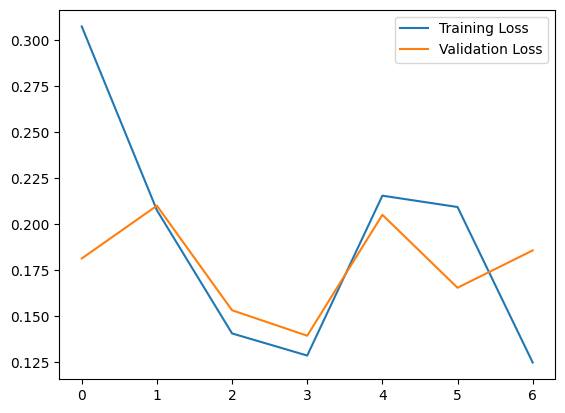

In [9]:
#       With Plot

import matplotlib.pyplot as plt

loss = history.history['loss'] # History of Loss Function
val_loss = history.history['val_loss'] # value of Loss Function

# Show plot

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.show()

Save Models, History Train And Tokenizer

In [10]:
import pickle

model.save('fake_news_lstm.h5') # Save model

with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save tokenizer

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f) # Save history

e:\asus\Machine Learning\LSTM\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
